In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib
import time
import numpy as np
import matplotlib.pyplot as plt

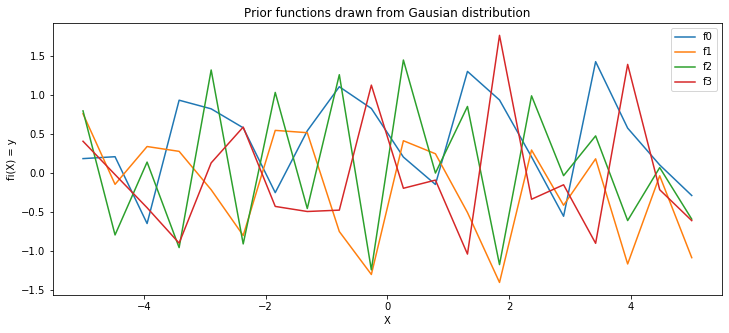

In [14]:
plot_gp_prior(4, n=20)

In [212]:
### Simple attention 

In [217]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units):
        super(Encoder, self).__init__()
#         self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, batch_sz):
        return tf.zeros((batch_sz, self.enc_units))

In [218]:
encoder = Encoder(32)

In [219]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, decoder_hidden, encoder_out):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(decoder_hidden_with_time_axis) + self.W2(encoder_out)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_out
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [220]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(1)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, dec_inp, dec_hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(dec_hidden, enc_output)
        

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), tf.expand_dims(dec_inp, 1)], 
                      axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [221]:
decoder = Decoder(32, 128)

In [222]:
optimizer = tf.keras.optimizers.Adam()
# loss_object = tf.keras.losses.mean_squared_error

def loss_function(real, pred):
#     mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.losses.mean_squared_error(real, pred)

#     # Casts a tensor to a new type.
#     mask = tf.cast(mask, dtype=loss_.dtype)
#     # equivalent to element-wise multiplication 
#     loss_ *= mask

    return tf.reduce_mean(loss_)

In [223]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(optimizer=optimizer,
#                                  encoder=encoder,
#                                  decoder=decoder)

In [224]:
# french_tr is the input to decoder
# 
@tf.function
def train_step(eng_tr, fren_tr, y_fren_tr, init_enc_hidden):

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(eng_tr, init_enc_hidden)

        dec_hidden = enc_hidden

        # basically same behavior as reshape
        dec_input = tf.expand_dims(fren_tr, 1)
        

        # Teacher forcing - feeding the target as the next input
#         for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          # pay attention that the decoder returns a new dec_hidden (which is the state of the GRU)
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss = loss_function(y_fren_tr, predictions)

            # using teacher forcing
#             dec_input = tf.expand_dims(targ[:, t], 1)

#     batch_loss = (loss / int(y_fren_tr.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))
    
    batch_loss(loss)

In [225]:
@tf.function
def test_step(eng_te, fren_te, y_fren_te, batch_s):
    init_enc_hidden = encoder.initialize_hidden_state(batch_s)
    enc_output, enc_hidden = encoder(eng_te, init_enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims(fren_te, 1)
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss = loss_function(y_fren_te, predictions)
    test_loss(loss)

In [226]:
batch_loss = tf.keras.metrics.Mean(name='batch_loss')

In [227]:
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [228]:
tf.keras.backend.set_floatx('float32')

In [230]:
EPOCHS = 80

for epoch in range(EPOCHS):
    start = time.time()

    batch_loss.reset_states()


    init_enc_hidden = encoder.initialize_hidden_state(128)

    for i in range(1000):
        b_eng_tr, b_fren_tr, b_y_fren_tr, _ = create_batch_gp_mim(eng_tr, fren_tr, y_fren_tr)
        train_step(b_eng_tr, b_fren_tr, b_y_fren_tr, init_enc_hidden)
        
        
        if i % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   i,
                                                   batch_loss.result()))
            test_step(eng_te, fren_te, y_fren_te, eng_te.shape[0])
        
            print('Epoch {} Batch {} test Loss {:.4f}'.format(epoch + 1,
                                                   i,
                                                   test_loss.result()))

Epoch 1 Batch 0 Loss 0.8388
Epoch 1 Batch 0 test Loss 1.1163
Epoch 1 Batch 50 Loss 0.7517
Epoch 1 Batch 50 test Loss 1.1166
Epoch 1 Batch 100 Loss 0.7596
Epoch 1 Batch 100 test Loss 1.1169
Epoch 1 Batch 150 Loss 0.7585
Epoch 1 Batch 150 test Loss 1.1171
Epoch 1 Batch 200 Loss 0.7584
Epoch 1 Batch 200 test Loss 1.1174
Epoch 1 Batch 250 Loss 0.7545
Epoch 1 Batch 250 test Loss 1.1177
Epoch 1 Batch 300 Loss 0.7520
Epoch 1 Batch 300 test Loss 1.1180
Epoch 1 Batch 350 Loss 0.7545
Epoch 1 Batch 350 test Loss 1.1183
Epoch 1 Batch 400 Loss 0.7552
Epoch 1 Batch 400 test Loss 1.1186
Epoch 1 Batch 450 Loss 0.7543
Epoch 1 Batch 450 test Loss 1.1189
Epoch 1 Batch 500 Loss 0.7538
Epoch 1 Batch 500 test Loss 1.1191
Epoch 1 Batch 550 Loss 0.7548
Epoch 1 Batch 550 test Loss 1.1194
Epoch 1 Batch 600 Loss 0.7561
Epoch 1 Batch 600 test Loss 1.1197
Epoch 1 Batch 650 Loss 0.7557
Epoch 1 Batch 650 test Loss 1.1200
Epoch 1 Batch 700 Loss 0.7556
Epoch 1 Batch 700 test Loss 1.1203
Epoch 1 Batch 750 Loss 0.7553
E

Epoch 7 Batch 350 Loss 0.7097
Epoch 7 Batch 350 test Loss 1.1497
Epoch 7 Batch 400 Loss 0.7104
Epoch 7 Batch 400 test Loss 1.1499
Epoch 7 Batch 450 Loss 0.7116
Epoch 7 Batch 450 test Loss 1.1502
Epoch 7 Batch 500 Loss 0.7098
Epoch 7 Batch 500 test Loss 1.1504
Epoch 7 Batch 550 Loss 0.7099
Epoch 7 Batch 550 test Loss 1.1507
Epoch 7 Batch 600 Loss 0.7102
Epoch 7 Batch 600 test Loss 1.1509
Epoch 7 Batch 650 Loss 0.7108
Epoch 7 Batch 650 test Loss 1.1511
Epoch 7 Batch 700 Loss 0.7093
Epoch 7 Batch 700 test Loss 1.1514
Epoch 7 Batch 750 Loss 0.7083
Epoch 7 Batch 750 test Loss 1.1516
Epoch 7 Batch 800 Loss 0.7071
Epoch 7 Batch 800 test Loss 1.1519
Epoch 7 Batch 850 Loss 0.7064
Epoch 7 Batch 850 test Loss 1.1522
Epoch 7 Batch 900 Loss 0.7070
Epoch 7 Batch 900 test Loss 1.1524
Epoch 7 Batch 950 Loss 0.7068
Epoch 7 Batch 950 test Loss 1.1526
Epoch 8 Batch 0 Loss 0.7083
Epoch 8 Batch 0 test Loss 1.1529
Epoch 8 Batch 50 Loss 0.7006
Epoch 8 Batch 50 test Loss 1.1531
Epoch 8 Batch 100 Loss 0.6995
E

Epoch 13 Batch 600 Loss 0.6745
Epoch 13 Batch 600 test Loss 1.1788
Epoch 13 Batch 650 Loss 0.6759
Epoch 13 Batch 650 test Loss 1.1790
Epoch 13 Batch 700 Loss 0.6756
Epoch 13 Batch 700 test Loss 1.1793
Epoch 13 Batch 750 Loss 0.6743
Epoch 13 Batch 750 test Loss 1.1795
Epoch 13 Batch 800 Loss 0.6746
Epoch 13 Batch 800 test Loss 1.1797
Epoch 13 Batch 850 Loss 0.6743
Epoch 13 Batch 850 test Loss 1.1799
Epoch 13 Batch 900 Loss 0.6735
Epoch 13 Batch 900 test Loss 1.1801
Epoch 13 Batch 950 Loss 0.6735
Epoch 13 Batch 950 test Loss 1.1803
Epoch 14 Batch 0 Loss 0.5337
Epoch 14 Batch 0 test Loss 1.1805
Epoch 14 Batch 50 Loss 0.6656
Epoch 14 Batch 50 test Loss 1.1807
Epoch 14 Batch 100 Loss 0.6614
Epoch 14 Batch 100 test Loss 1.1810
Epoch 14 Batch 150 Loss 0.6682
Epoch 14 Batch 150 test Loss 1.1812
Epoch 14 Batch 200 Loss 0.6685
Epoch 14 Batch 200 test Loss 1.1814
Epoch 14 Batch 250 Loss 0.6712
Epoch 14 Batch 250 test Loss 1.1816
Epoch 14 Batch 300 Loss 0.6695
Epoch 14 Batch 300 test Loss 1.1818
E

Epoch 19 Batch 750 Loss 0.6502
Epoch 19 Batch 750 test Loss 1.2044
Epoch 19 Batch 800 Loss 0.6511
Epoch 19 Batch 800 test Loss 1.2046
Epoch 19 Batch 850 Loss 0.6505
Epoch 19 Batch 850 test Loss 1.2048
Epoch 19 Batch 900 Loss 0.6496
Epoch 19 Batch 900 test Loss 1.2050
Epoch 19 Batch 950 Loss 0.6492
Epoch 19 Batch 950 test Loss 1.2052
Epoch 20 Batch 0 Loss 0.6509
Epoch 20 Batch 0 test Loss 1.2054
Epoch 20 Batch 50 Loss 0.6192
Epoch 20 Batch 50 test Loss 1.2056
Epoch 20 Batch 100 Loss 0.6287
Epoch 20 Batch 100 test Loss 1.2058
Epoch 20 Batch 150 Loss 0.6291
Epoch 20 Batch 150 test Loss 1.2060
Epoch 20 Batch 200 Loss 0.6300
Epoch 20 Batch 200 test Loss 1.2062
Epoch 20 Batch 250 Loss 0.6355
Epoch 20 Batch 250 test Loss 1.2064
Epoch 20 Batch 300 Loss 0.6359
Epoch 20 Batch 300 test Loss 1.2066
Epoch 20 Batch 350 Loss 0.6366
Epoch 20 Batch 350 test Loss 1.2068
Epoch 20 Batch 400 Loss 0.6361
Epoch 20 Batch 400 test Loss 1.2070
Epoch 20 Batch 450 Loss 0.6388
Epoch 20 Batch 450 test Loss 1.2072
E

Epoch 25 Batch 900 Loss 0.6284
Epoch 25 Batch 900 test Loss 1.2277
Epoch 25 Batch 950 Loss 0.6290
Epoch 25 Batch 950 test Loss 1.2278
Epoch 26 Batch 0 Loss 0.5537
Epoch 26 Batch 0 test Loss 1.2280
Epoch 26 Batch 50 Loss 0.6109
Epoch 26 Batch 50 test Loss 1.2282
Epoch 26 Batch 100 Loss 0.6183
Epoch 26 Batch 100 test Loss 1.2284
Epoch 26 Batch 150 Loss 0.6235
Epoch 26 Batch 150 test Loss 1.2286
Epoch 26 Batch 200 Loss 0.6296
Epoch 26 Batch 200 test Loss 1.2287
Epoch 26 Batch 250 Loss 0.6255
Epoch 26 Batch 250 test Loss 1.2289
Epoch 26 Batch 300 Loss 0.6278
Epoch 26 Batch 300 test Loss 1.2291
Epoch 26 Batch 350 Loss 0.6246
Epoch 26 Batch 350 test Loss 1.2293
Epoch 26 Batch 400 Loss 0.6234
Epoch 26 Batch 400 test Loss 1.2294
Epoch 26 Batch 450 Loss 0.6232
Epoch 26 Batch 450 test Loss 1.2296
Epoch 26 Batch 500 Loss 0.6225
Epoch 26 Batch 500 test Loss 1.2298
Epoch 26 Batch 550 Loss 0.6252
Epoch 26 Batch 550 test Loss 1.2300
Epoch 26 Batch 600 Loss 0.6252
Epoch 26 Batch 600 test Loss 1.2302
E

Epoch 32 Batch 50 Loss 0.6026
Epoch 32 Batch 50 test Loss 1.2485
Epoch 32 Batch 100 Loss 0.6060
Epoch 32 Batch 100 test Loss 1.2487
Epoch 32 Batch 150 Loss 0.6071
Epoch 32 Batch 150 test Loss 1.2488
Epoch 32 Batch 200 Loss 0.6069
Epoch 32 Batch 200 test Loss 1.2490
Epoch 32 Batch 250 Loss 0.6112
Epoch 32 Batch 250 test Loss 1.2492
Epoch 32 Batch 300 Loss 0.6090
Epoch 32 Batch 300 test Loss 1.2493
Epoch 32 Batch 350 Loss 0.6090
Epoch 32 Batch 350 test Loss 1.2494
Epoch 32 Batch 400 Loss 0.6084
Epoch 32 Batch 400 test Loss 1.2496
Epoch 32 Batch 450 Loss 0.6073
Epoch 32 Batch 450 test Loss 1.2498
Epoch 32 Batch 500 Loss 0.6075
Epoch 32 Batch 500 test Loss 1.2499
Epoch 32 Batch 550 Loss 0.6073
Epoch 32 Batch 550 test Loss 1.2501
Epoch 32 Batch 600 Loss 0.6084
Epoch 32 Batch 600 test Loss 1.2502
Epoch 32 Batch 650 Loss 0.6082
Epoch 32 Batch 650 test Loss 1.2504
Epoch 32 Batch 700 Loss 0.6093
Epoch 32 Batch 700 test Loss 1.2506
Epoch 32 Batch 750 Loss 0.6079
Epoch 32 Batch 750 test Loss 1.25

Epoch 38 Batch 200 Loss 0.6033
Epoch 38 Batch 200 test Loss 1.2671
Epoch 38 Batch 250 Loss 0.5991
Epoch 38 Batch 250 test Loss 1.2672
Epoch 38 Batch 300 Loss 0.5974
Epoch 38 Batch 300 test Loss 1.2673
Epoch 38 Batch 350 Loss 0.5968
Epoch 38 Batch 350 test Loss 1.2675
Epoch 38 Batch 400 Loss 0.5961
Epoch 38 Batch 400 test Loss 1.2676
Epoch 38 Batch 450 Loss 0.5962
Epoch 38 Batch 450 test Loss 1.2677
Epoch 38 Batch 500 Loss 0.5964
Epoch 38 Batch 500 test Loss 1.2679
Epoch 38 Batch 550 Loss 0.5957
Epoch 38 Batch 550 test Loss 1.2680
Epoch 38 Batch 600 Loss 0.5958
Epoch 38 Batch 600 test Loss 1.2682
Epoch 38 Batch 650 Loss 0.5973
Epoch 38 Batch 650 test Loss 1.2683
Epoch 38 Batch 700 Loss 0.5971
Epoch 38 Batch 700 test Loss 1.2684
Epoch 38 Batch 750 Loss 0.5963
Epoch 38 Batch 750 test Loss 1.2686
Epoch 38 Batch 800 Loss 0.5962
Epoch 38 Batch 800 test Loss 1.2687
Epoch 38 Batch 850 Loss 0.5956
Epoch 38 Batch 850 test Loss 1.2688
Epoch 38 Batch 900 Loss 0.5954
Epoch 38 Batch 900 test Loss 1.

Epoch 44 Batch 350 Loss 0.5941
Epoch 44 Batch 350 test Loss 1.2837
Epoch 44 Batch 400 Loss 0.5932
Epoch 44 Batch 400 test Loss 1.2838
Epoch 44 Batch 450 Loss 0.5920
Epoch 44 Batch 450 test Loss 1.2840
Epoch 44 Batch 500 Loss 0.5919
Epoch 44 Batch 500 test Loss 1.2841
Epoch 44 Batch 550 Loss 0.5899
Epoch 44 Batch 550 test Loss 1.2842
Epoch 44 Batch 600 Loss 0.5905
Epoch 44 Batch 600 test Loss 1.2843
Epoch 44 Batch 650 Loss 0.5903
Epoch 44 Batch 650 test Loss 1.2844
Epoch 44 Batch 700 Loss 0.5896
Epoch 44 Batch 700 test Loss 1.2846
Epoch 44 Batch 750 Loss 0.5886
Epoch 44 Batch 750 test Loss 1.2847
Epoch 44 Batch 800 Loss 0.5873
Epoch 44 Batch 800 test Loss 1.2848
Epoch 44 Batch 850 Loss 0.5875
Epoch 44 Batch 850 test Loss 1.2849
Epoch 44 Batch 900 Loss 0.5879
Epoch 44 Batch 900 test Loss 1.2850
Epoch 44 Batch 950 Loss 0.5888
Epoch 44 Batch 950 test Loss 1.2852
Epoch 45 Batch 0 Loss 0.6379
Epoch 45 Batch 0 test Loss 1.2853
Epoch 45 Batch 50 Loss 0.5793
Epoch 45 Batch 50 test Loss 1.2854
E

Epoch 50 Batch 500 Loss 0.5760
Epoch 50 Batch 500 test Loss 1.2980
Epoch 50 Batch 550 Loss 0.5751
Epoch 50 Batch 550 test Loss 1.2981
Epoch 50 Batch 600 Loss 0.5747
Epoch 50 Batch 600 test Loss 1.2982
Epoch 50 Batch 650 Loss 0.5757
Epoch 50 Batch 650 test Loss 1.2983
Epoch 50 Batch 700 Loss 0.5748
Epoch 50 Batch 700 test Loss 1.2984
Epoch 50 Batch 750 Loss 0.5745
Epoch 50 Batch 750 test Loss 1.2985
Epoch 50 Batch 800 Loss 0.5749
Epoch 50 Batch 800 test Loss 1.2987
Epoch 50 Batch 850 Loss 0.5752
Epoch 50 Batch 850 test Loss 1.2988
Epoch 50 Batch 900 Loss 0.5756
Epoch 50 Batch 900 test Loss 1.2989
Epoch 50 Batch 950 Loss 0.5757
Epoch 50 Batch 950 test Loss 1.2990
Epoch 51 Batch 0 Loss 0.6689
Epoch 51 Batch 0 test Loss 1.2991
Epoch 51 Batch 50 Loss 0.5702
Epoch 51 Batch 50 test Loss 1.2992
Epoch 51 Batch 100 Loss 0.5740
Epoch 51 Batch 100 test Loss 1.2994
Epoch 51 Batch 150 Loss 0.5737
Epoch 51 Batch 150 test Loss 1.2995
Epoch 51 Batch 200 Loss 0.5735
Epoch 51 Batch 200 test Loss 1.2996
E

Epoch 56 Batch 650 Loss 0.5760
Epoch 56 Batch 650 test Loss 1.3110
Epoch 56 Batch 700 Loss 0.5756
Epoch 56 Batch 700 test Loss 1.3111
Epoch 56 Batch 750 Loss 0.5760
Epoch 56 Batch 750 test Loss 1.3112
Epoch 56 Batch 800 Loss 0.5756
Epoch 56 Batch 800 test Loss 1.3113
Epoch 56 Batch 850 Loss 0.5752
Epoch 56 Batch 850 test Loss 1.3114
Epoch 56 Batch 900 Loss 0.5744
Epoch 56 Batch 900 test Loss 1.3115
Epoch 56 Batch 950 Loss 0.5742
Epoch 56 Batch 950 test Loss 1.3116
Epoch 57 Batch 0 Loss 0.6112
Epoch 57 Batch 0 test Loss 1.3117
Epoch 57 Batch 50 Loss 0.5735
Epoch 57 Batch 50 test Loss 1.3118
Epoch 57 Batch 100 Loss 0.5618
Epoch 57 Batch 100 test Loss 1.3119
Epoch 57 Batch 150 Loss 0.5668
Epoch 57 Batch 150 test Loss 1.3120
Epoch 57 Batch 200 Loss 0.5675
Epoch 57 Batch 200 test Loss 1.3121
Epoch 57 Batch 250 Loss 0.5676
Epoch 57 Batch 250 test Loss 1.3122
Epoch 57 Batch 300 Loss 0.5673
Epoch 57 Batch 300 test Loss 1.3123
Epoch 57 Batch 350 Loss 0.5643
Epoch 57 Batch 350 test Loss 1.3124
E

Epoch 62 Batch 800 Loss 0.5636
Epoch 62 Batch 800 test Loss 1.3229
Epoch 62 Batch 850 Loss 0.5635
Epoch 62 Batch 850 test Loss 1.3230
Epoch 62 Batch 900 Loss 0.5629
Epoch 62 Batch 900 test Loss 1.3231
Epoch 62 Batch 950 Loss 0.5622
Epoch 62 Batch 950 test Loss 1.3232
Epoch 63 Batch 0 Loss 0.6009
Epoch 63 Batch 0 test Loss 1.3233
Epoch 63 Batch 50 Loss 0.5702
Epoch 63 Batch 50 test Loss 1.3234
Epoch 63 Batch 100 Loss 0.5713
Epoch 63 Batch 100 test Loss 1.3235
Epoch 63 Batch 150 Loss 0.5720
Epoch 63 Batch 150 test Loss 1.3236
Epoch 63 Batch 200 Loss 0.5689
Epoch 63 Batch 200 test Loss 1.3237
Epoch 63 Batch 250 Loss 0.5710
Epoch 63 Batch 250 test Loss 1.3238
Epoch 63 Batch 300 Loss 0.5705
Epoch 63 Batch 300 test Loss 1.3239
Epoch 63 Batch 350 Loss 0.5676
Epoch 63 Batch 350 test Loss 1.3239
Epoch 63 Batch 400 Loss 0.5692
Epoch 63 Batch 400 test Loss 1.3240
Epoch 63 Batch 450 Loss 0.5676
Epoch 63 Batch 450 test Loss 1.3241
Epoch 63 Batch 500 Loss 0.5690
Epoch 63 Batch 500 test Loss 1.3242
E

Epoch 68 Batch 950 Loss 0.5638
Epoch 68 Batch 950 test Loss 1.3337
Epoch 69 Batch 0 Loss 0.5389
Epoch 69 Batch 0 test Loss 1.3337
Epoch 69 Batch 50 Loss 0.5433
Epoch 69 Batch 50 test Loss 1.3338
Epoch 69 Batch 100 Loss 0.5562
Epoch 69 Batch 100 test Loss 1.3339
Epoch 69 Batch 150 Loss 0.5605
Epoch 69 Batch 150 test Loss 1.3340
Epoch 69 Batch 200 Loss 0.5626
Epoch 69 Batch 200 test Loss 1.3341
Epoch 69 Batch 250 Loss 0.5631
Epoch 69 Batch 250 test Loss 1.3342
Epoch 69 Batch 300 Loss 0.5600
Epoch 69 Batch 300 test Loss 1.3342
Epoch 69 Batch 350 Loss 0.5618
Epoch 69 Batch 350 test Loss 1.3343
Epoch 69 Batch 400 Loss 0.5596
Epoch 69 Batch 400 test Loss 1.3344
Epoch 69 Batch 450 Loss 0.5583
Epoch 69 Batch 450 test Loss 1.3345
Epoch 69 Batch 500 Loss 0.5579
Epoch 69 Batch 500 test Loss 1.3346
Epoch 69 Batch 550 Loss 0.5564
Epoch 69 Batch 550 test Loss 1.3347
Epoch 69 Batch 600 Loss 0.5566
Epoch 69 Batch 600 test Loss 1.3347
Epoch 69 Batch 650 Loss 0.5579
Epoch 69 Batch 650 test Loss 1.3348
E

Epoch 75 Batch 100 Loss 0.5506
Epoch 75 Batch 100 test Loss 1.3436
Epoch 75 Batch 150 Loss 0.5530
Epoch 75 Batch 150 test Loss 1.3437
Epoch 75 Batch 200 Loss 0.5504
Epoch 75 Batch 200 test Loss 1.3437
Epoch 75 Batch 250 Loss 0.5521
Epoch 75 Batch 250 test Loss 1.3438
Epoch 75 Batch 300 Loss 0.5533
Epoch 75 Batch 300 test Loss 1.3439
Epoch 75 Batch 350 Loss 0.5519
Epoch 75 Batch 350 test Loss 1.3440
Epoch 75 Batch 400 Loss 0.5513
Epoch 75 Batch 400 test Loss 1.3441
Epoch 75 Batch 450 Loss 0.5495
Epoch 75 Batch 450 test Loss 1.3441
Epoch 75 Batch 500 Loss 0.5492
Epoch 75 Batch 500 test Loss 1.3442
Epoch 75 Batch 550 Loss 0.5496
Epoch 75 Batch 550 test Loss 1.3443
Epoch 75 Batch 600 Loss 0.5506
Epoch 75 Batch 600 test Loss 1.3444
Epoch 75 Batch 650 Loss 0.5506
Epoch 75 Batch 650 test Loss 1.3445
Epoch 75 Batch 700 Loss 0.5498
Epoch 75 Batch 700 test Loss 1.3446
Epoch 75 Batch 750 Loss 0.5503
Epoch 75 Batch 750 test Loss 1.3446
Epoch 75 Batch 800 Loss 0.5497
Epoch 75 Batch 800 test Loss 1.

In [196]:
    init_enc_hidden = encoder.initialize_hidden_state(1000)
    enc_output, enc_hidden = encoder(eng_te, init_enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims(fren_te, 1)
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

In [209]:
sum(( predictions - y_fren_te) ** 2) / 1000

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.2934513], dtype=float32)>

In [210]:
encoder.trainable_variables

[<tf.Variable 'encoder_5/gru_12/gru_cell_12/kernel:0' shape=(2, 96) dtype=float32, numpy=
 array([[-0.24294144, -0.12160824, -0.04108305, -0.13510454, -0.4508549 ,
          0.08995712,  0.46263385,  0.02382828, -0.1736701 , -0.08664411,
         -0.0645362 ,  0.10717343,  0.39027807, -0.2536707 ,  0.26978347,
          0.21451135,  0.17279914, -0.22395223,  0.38327673,  0.5131383 ,
         -0.6774076 , -0.00840344, -0.01552058,  0.20810582, -0.06036491,
         -0.01459866, -0.7317905 ,  0.41818264,  0.12667684, -0.08040617,
          0.02328785, -0.849636  ,  0.3476957 , -0.09011477, -0.33210495,
          0.18907492,  0.79412216, -0.46108374, -0.7936108 , -0.47735268,
         -0.2614186 ,  0.17455386, -0.41601086,  0.1933774 , -0.2497674 ,
          0.22317033, -0.08189869, -0.03433538, -0.23077747,  0.57423216,
          0.43720472, -0.4934506 ,  0.859332  ,  0.3871569 ,  0.452166  ,
          0.41956085,  0.42980555,  0.23904507,  0.23489945,  0.16605651,
         -0.22875607, 

In [38]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /Users/omernivron/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCN89RD/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /Users/omernivron/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCN89RD/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /Users/omernivron/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCN89RD/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /Users/omernivron/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [39]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [102]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [41]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [42]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [43]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
    return lang1, lang2

In [44]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [45]:
MAX_LENGTH = 40

In [46]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [47]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [49]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [50]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [51]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [52]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


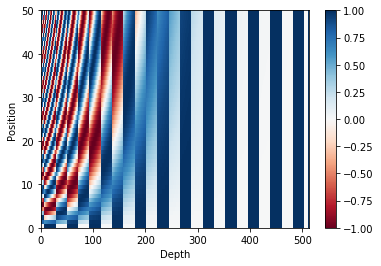

In [53]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
# the mask indicates which entries should not be used.

In [54]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [55]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [56]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [57]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [58]:
x

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.25745153, 0.22060382, 0.59445953]], dtype=float32)>

In [60]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [61]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [62]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [63]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [64]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [135]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        
#         print('value: ', v)
#         print('key: ', k)
#         print('query: ', q)
        
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [105]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

value:  tf.Tensor(
[[[0.93007994 0.07386124 0.12029994 ... 0.7008438  0.0717392  0.26032686]
  [0.48606646 0.7353846  0.41520226 ... 0.35724092 0.27602732 0.86372983]
  [0.41987157 0.8600621  0.10850787 ... 0.467916   0.99416685 0.17329168]
  ...
  [0.12135828 0.24125612 0.59066045 ... 0.6352788  0.778121   0.11662745]
  [0.4706217  0.46683395 0.69353175 ... 0.56884396 0.90624857 0.3799808 ]
  [0.5592438  0.9700223  0.72765493 ... 0.13796568 0.9331293  0.17192411]]], shape=(1, 60, 512), dtype=float32)
key:  tf.Tensor(
[[[0.93007994 0.07386124 0.12029994 ... 0.7008438  0.0717392  0.26032686]
  [0.48606646 0.7353846  0.41520226 ... 0.35724092 0.27602732 0.86372983]
  [0.41987157 0.8600621  0.10850787 ... 0.467916   0.99416685 0.17329168]
  ...
  [0.12135828 0.24125612 0.59066045 ... 0.6352788  0.778121   0.11662745]
  [0.4706217  0.46683395 0.69353175 ... 0.56884396 0.90624857 0.3799808 ]
  [0.5592438  0.9700223  0.72765493 ... 0.13796568 0.9331293  0.17192411]]], shape=(1, 60, 512), dty

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [106]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [107]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [108]:
# The input sentence is passed through N encoder layers 
# that generates an output for each word/token in the sequence.

# The decoder attends on the encoder's output and
# its own input (self-attention) to predict the next word.


In [109]:
# Encoder layer

# Each encoder layer consists of sublayers:

# Multi-head attention (with padding mask)
# Point wise feed forward networks.

In [110]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [136]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [112]:
# Decoder layer

# Each decoder layer consists of sublayers:

# Masked multi-head attention (with look ahead mask and padding mask)
# Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
# Point wise feed forward networks

In [137]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [138]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [139]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
#         print('encoder_x_inp: ', x)
#         print('encoder_mask: ', mask)

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
#         print('encoded_x_after_embedding: ', x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [140]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [308]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    #a call method, the layer's forward pass
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [142]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [143]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [144]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [145]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [146]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

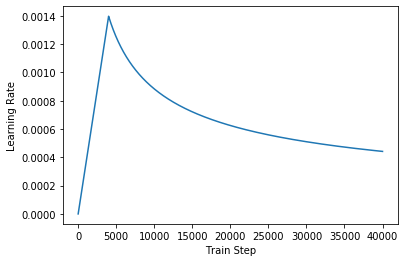

In [147]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [148]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')



In [149]:
# Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [150]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [151]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [152]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [153]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [154]:
# Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.


checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [155]:
# The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. 
# tar_real is that same input shifted by 1: 
#     At each location in tar_input, tar_real contains the next token that should be predicted.

In [156]:
# For example, sentence = "SOS A lion in the jungle is sleeping EOS"

# tar_inp = "SOS A lion in the jungle is sleeping"

# tar_real = "A lion in the jungle is sleeping EOS"

In [157]:
# Teacher forcing is passing the true output to the next time step
# regardless of what the model predicts at the current time step.

In [158]:
# To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [159]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    print('enc_padding_mask: ', enc_padding_mask)
    print('dec_padding_mask: ', dec_padding_mask)



    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [162]:
EPOCHS = 1

In [166]:
inp[0, :]

<tf.Tensor: shape=(37,), dtype=int64, numpy=
array([8214,   42,    8,  131, 3491, 7990,  155,    2, 8215,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])>

In [167]:
tar[0, :]

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([8087,   16,   13,   18, 7375,  492,  111,    2, 8088,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [165]:
inp[1, :]

<tf.Tensor: shape=(37,), dtype=int64, numpy=
array([8214,   32, 7095,  136,   72,   95,    3, 5768, 8072, 8003,   16,
         22, 6014, 7990,    6,  400,    3, 2155, 8055,   93,  125,   11,
          3, 2637,    1, 1837, 7106,  232,    1,  500,   14, 1944,   37,
       8215,    0,    0,    0])>

In [168]:
tar[1, :]

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([8087,   62, 3257, 5032, 7863,   20,  114, 6540, 7863,   11, 3029,
          1,    4,   65,  298,    5,  197, 3802,  116,  190,    8,    9,
        120,    5, 1763,  231, 7012, 6455, 5112,    1, 1515,  403,   75,
       8088,    0,    0,    0,    0])>

In [163]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        print('inp: ', inp)
        print('tar: ', tar)
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

inp:  tf.Tensor(
[[8214    9 1356 ...    0    0    0]
 [8214   77   42 ...    0    0    0]
 [8214  610 8003 ...  589 8215    0]
 ...
 [8214   64 7265 ...    0    0    0]
 [8214   78   16 ...    0    0    0]
 [8214   27 1389 ...    0    0    0]], shape=(64, 38), dtype=int64)
tar:  tf.Tensor(
[[8087    7  855 ...    0    0    0]
 [8087   18   16 ...    0    0    0]
 [8087  229   81 ... 8088    0    0]
 ...
 [8087   14  134 ...    0    0    0]
 [8087  115   44 ...    0    0    0]
 [8087   12   20 ...    0    0    0]], shape=(64, 39), dtype=int64)
Epoch 1 Batch 0 Loss 8.9562 Accuracy 0.0008
inp:  tf.Tensor(
[[8214    7 1591 ...    0    0    0]
 [8214 5130  180 ...    0    0    0]
 [8214   56  131 ...    0    0    0]
 ...
 [8214    8 6487 ...    0    0    0]
 [8214 1455  543 ...    0    0    0]
 [8214   24  402 ...    0    0    0]], shape=(64, 38), dtype=int64)
tar:  tf.Tensor(
[[8087 1173 1493 ...    0    0    0]
 [8087  134   16 ...    0    0    0]
 [8087   17   20 ... 8088    0    0]
 ..

inp:  tf.Tensor(
[[8214  229    4 ...    0    0    0]
 [8214   13  324 ...    0    0    0]
 [8214  195    1 ...    0    0    0]
 ...
 [8214   46  174 ...    0    0    0]
 [8214  194    1 ...    0    0    0]
 [8214   12  954 ...    0    0    0]], shape=(64, 35), dtype=int64)
tar:  tf.Tensor(
[[8087   14   90 ...    0    0    0]
 [8087   64   20 ...    0    0    0]
 [8087  803    1 ...    0    0    0]
 ...
 [8087   18   64 ...    0    0    0]
 [8087   18 6985 ...    0    0    0]
 [8087    3 1040 ...    0    0    0]], shape=(64, 33), dtype=int64)
inp:  tf.Tensor(
[[8214   67   92 ... 6703    2 8215]
 [8214 1830    5 ...    0    0    0]
 [8214   47   66 ...    0    0    0]
 ...
 [8214  282  210 ...    0    0    0]
 [8214   54   56 ...    0    0    0]
 [8214    6   14 ...    2 8215    0]], shape=(64, 38), dtype=int64)
tar:  tf.Tensor(
[[8087   94  119 ...    2 8088    0]
 [8087   25   70 ...    0    0    0]
 [8087   66   25 ...    0    0    0]
 ...
 [8087   12  333 ...    0    0    0]
 [808

inp:  tf.Tensor(
[[8214 5893   57 ...    0    0    0]
 [8214    7    5 ...    0    0    0]
 [8214    8  347 ...    0    0    0]
 ...
 [8214   25 3217 ...    0    0    0]
 [8214   25  140 ...    0    0    0]
 [8214   64   76 ...    0    0    0]], shape=(64, 35), dtype=int64)
tar:  tf.Tensor(
[[8087 2405   77 ...    0    0    0]
 [8087  196    8 ...    0    0    0]
 [8087    6  278 ...    0    0    0]
 ...
 [8087   23   12 ...    0    0    0]
 [8087   23   11 ...    0    0    0]
 [8087   14   31 ...    0    0    0]], shape=(64, 37), dtype=int64)
inp:  tf.Tensor(
[[8214 2685   79 ...    0    0    0]
 [8214   54    8 ...    0    0    0]
 [8214  191 5079 ...    0    0    0]
 ...
 [8214  568 8003 ...    0    0    0]
 [8214   42 1965 ...    0    0    0]
 [8214    5 1092 ...    0    0    0]], shape=(64, 39), dtype=int64)
tar:  tf.Tensor(
[[8087   14   97 ...    0    0    0]
 [8087   16   13 ...    0    0    0]
 [8087   18  255 ...    0    0    0]
 ...
 [8087   14   22 ...    0    0    0]
 [808

KeyboardInterrupt: 

In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [101]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: 
Real translation: this is a problem we have to solve .


In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


In [18]:
# Every v1.Session.run call should be replaced by a Python function.
# The feed_dict and v1.placeholders become function arguments.
# The fetches become the function's return value.
# After that add a tf.function decorator to make it run efficiently in graph. 